In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import torch


## Import Libraries

All necessary libraries for data manipulation, visualization, and machine learning.

In [8]:
df_movies = pd.read_csv('tmdb_commercial_movies_2016_2024.csv')
df_movies.head()

,tmdb_id,title,original_title,release_date,year,original_language,genres,budget,revenue_worldwide,runtime,popularity,vote_average,vote_count,production_companies,production_countries,director,top_3_cast,overview,adult
0,269149,Zootopia,Zootopia,2016-02-11,2016,en,"Animation, Adventure, Family, Comedy",150000000,1025521689,109,122.0547,7.755,17200,Walt Disney Animation Studios,United States of America,Byron Howard,"Ginnifer Goodwin, Jason Bateman, Idris Elba","Determined to prove herself, Officer Judy Hopp...",False
1,372058,Your Name.,君の名は。,2016-08-26,2016,ja,"Animation, Romance, Drama",0,358000000,106,26.7148,8.480,12136,"CoMix Wave Films, TOHO, KADOKAWA, jeki, AMUSE,...",Japan,Makoto Shinkai,"Ryunosuke Kamiki, Mone Kamishiraishi, Ryo Narita",High schoolers Mitsuha and Taki are complete s...,False
2,291805,Now You See Me 2,Now You See Me 2,2016-06-02,2016,en,"Thriller, Crime",120000000,334897606,129,14.5408,6.827,11211,"Summit Entertainment, K/O Paper Products, TIK ...","Hong Kong, United States of America",Jon M. Chu,"Jesse Eisenberg, Mark Ruffalo, Woody Harrelson",One year after outwitting the FBI and winning ...,False
3,271110,Captain America: Civil War,Captain America: Civil War,2016-04-27,2016,en,"Adventure, Action, Science Fiction",250000000,1155046416,147,12.2320,7.448,23541,Marvel Studios,United States of America,Joe Russo,"Chris Evans, Robert Downey Jr., Scarlett Johan...","Following the events of Age of Ultron, the col...",False
4,296096,Me Before You,Me Before You,2016-06-01,2016,en,"Drama, Romance",20000000,207945075,110,13.7781,7.926,12901,"New Line Cinema, Sunswept Entertainment, Metro...",United States of America,Thea Sharrock,"Emilia Clarke, Sam Claflin, Janet McTeer",A small town girl is caught between dead-end j...,False


## Load and Prepare Data

Loading TMDB movie data and sentiment analysis results.

In [10]:
df_sentiment = pd.read_csv('../exports/movies_20251208_113157.csv')
df_sentiment.head()
df_sentiment.drop(columns=['genres','sentiment_rt_all_critics_avg', 'sentiment_rt_top_critics_avg', 'sentiment_rt_verified_audience_avg', 'sentiment_rt_all_audience_avg'], inplace=True)
df_sentiment.head()

,id,title,year,tmdb_rating,imdb_rating,tmdb_votes,imdb_votes,rt_tomatometer,rt_tomatometer_out_of_10,sentiment_imdb_avg
0,1,Zootopia,2016,7.755,8.0,17200,604397.0,98.0,9.8,0.816788
1,2,Your Name.,2016,8.480,8.4,12136,377296.0,98.0,9.8,0.797133
2,3,Now You See Me 2,2016,6.827,6.4,11211,352325.0,34.0,3.4,0.560476
3,4,Captain America: Civil War,2016,7.448,7.8,23541,910805.0,90.0,9.0,0.668683
4,5,Me Before You,2016,7.926,7.4,12901,322865.0,55.0,5.5,0.661296


In [11]:
df = pd.concat([df_movies.reset_index(drop=True),
                df_sentiment.reset_index(drop=True)], axis=1)

df.head()

,tmdb_id,title,original_title,release_date,year,original_language,genres,budget,revenue_worldwide,runtime,...,id,title,year,tmdb_rating,imdb_rating,tmdb_votes,imdb_votes,rt_tomatometer,rt_tomatometer_out_of_10,sentiment_imdb_avg
0,269149,Zootopia,Zootopia,2016-02-11,2016,en,"Animation, Adventure, Family, Comedy",150000000,1025521689,109,...,1.0,Zootopia,2016.0,7.755,8.0,17200.0,604397.0,98.0,9.8,0.816788
1,372058,Your Name.,君の名は。,2016-08-26,2016,ja,"Animation, Romance, Drama",0,358000000,106,...,2.0,Your Name.,2016.0,8.480,8.4,12136.0,377296.0,98.0,9.8,0.797133
2,291805,Now You See Me 2,Now You See Me 2,2016-06-02,2016,en,"Thriller, Crime",120000000,334897606,129,...,3.0,Now You See Me 2,2016.0,6.827,6.4,11211.0,352325.0,34.0,3.4,0.560476
3,271110,Captain America: Civil War,Captain America: Civil War,2016-04-27,2016,en,"Adventure, Action, Science Fiction",250000000,1155046416,147,...,4.0,Captain America: Civil War,2016.0,7.448,7.8,23541.0,910805.0,90.0,9.0,0.668683
4,296096,Me Before You,Me Before You,2016-06-01,2016,en,"Drama, Romance",20000000,207945075,110,...,5.0,Me Before You,2016.0,7.926,7.4,12901.0,322865.0,55.0,5.5,0.661296


Combine movie data with sentiment features.

In [12]:
def clean_genres(g):
    if pd.isna(g): return []
    if isinstance(g, str):
        return [x.strip() for x in g.split(",")]
    return g  # if already list-like

df["genre_list"] = df["genres"].apply(clean_genres)

# One-hot encode all unique genres
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
genre_dummies = pd.DataFrame(mlb.fit_transform(df["genre_list"]),
                             columns=mlb.classes_)

df = pd.concat([df, genre_dummies], axis=1)
df.head()

,tmdb_id,title,original_title,release_date,year,original_language,genres,budget,revenue_worldwide,runtime,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,269149,Zootopia,Zootopia,2016-02-11,2016,en,"Animation, Adventure, Family, Comedy",150000000,1025521689,109,...,0,0,0,0,0,0,0,0,0,0
1,372058,Your Name.,君の名は。,2016-08-26,2016,ja,"Animation, Romance, Drama",0,358000000,106,...,0,0,0,0,1,0,0,0,0,0
2,291805,Now You See Me 2,Now You See Me 2,2016-06-02,2016,en,"Thriller, Crime",120000000,334897606,129,...,0,0,0,0,0,0,0,1,0,0
3,271110,Captain America: Civil War,Captain America: Civil War,2016-04-27,2016,en,"Adventure, Action, Science Fiction",250000000,1155046416,147,...,0,0,0,0,0,1,0,0,0,0
4,296096,Me Before You,Me Before You,2016-06-01,2016,en,"Drama, Romance",20000000,207945075,110,...,0,0,0,0,1,0,0,0,0,0


## Feature Engineering

One-hot encode genres for machine learning compatibility.

In [13]:
top_directors = {
    "Christopher Nolan", "Denis Villeneuve", "Steven Spielberg",
    "James Cameron", "Martin Scorsese", "Ridley Scott"
} #this is hard-coded, can be changed

top_actors = {
    "Leonardo DiCaprio", "Tom Cruise", "Brad Pitt",
    "Zendaya", "Timothée Chalamet", "Emma Stone",
    "Robert Downey Jr", "Scarlett Johansson", "Christian Bale"
} #again hard-coded, can be changed
df["is_top_director"] = df["director"].apply(lambda x: x in top_directors)
df["has_top_actor"] = df["top_3_cast"].apply(
    lambda x: any(actor in top_actors for actor in clean_genres(x))
)
df.head()

,tmdb_id,title,original_title,release_date,year,original_language,genres,budget,revenue_worldwide,runtime,...,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,is_top_director,has_top_actor
0,269149,Zootopia,Zootopia,2016-02-11,2016,en,"Animation, Adventure, Family, Comedy",150000000,1025521689,109,...,0,0,0,0,0,0,0,0,False,False
1,372058,Your Name.,君の名は。,2016-08-26,2016,ja,"Animation, Romance, Drama",0,358000000,106,...,0,0,1,0,0,0,0,0,False,False
2,291805,Now You See Me 2,Now You See Me 2,2016-06-02,2016,en,"Thriller, Crime",120000000,334897606,129,...,0,0,0,0,0,1,0,0,False,False
3,271110,Captain America: Civil War,Captain America: Civil War,2016-04-27,2016,en,"Adventure, Action, Science Fiction",250000000,1155046416,147,...,0,0,0,1,0,0,0,0,False,True
4,296096,Me Before You,Me Before You,2016-06-01,2016,en,"Drama, Romance",20000000,207945075,110,...,0,0,1,0,0,0,0,0,False,False


Create features for top directors and actors.

In [14]:
def classify_verdict(row):
    b = row["budget"]
    w = row["revenue_worldwide"]

    if w < 2*b:
        return 0 #average/flop
    elif 2*b < w <= 6*b:
        return 1 #hit/superhit
    else:
        return 2 #blockbuster

df["verdict"] = df.apply(classify_verdict, axis=1)
print(df["verdict"].value_counts())
print(df.columns)
print(df['original_language'].value_counts())
print(df["production_countries"].value_counts())
print(df["production_companies"].value_counts())


verdict
2    992
0    769
1    427
Name: count, dtype: int64
Index(['tmdb_id', 'title', 'original_title', 'release_date', 'year',
       'original_language', 'genres', 'budget', 'revenue_worldwide', 'runtime',
       'popularity', 'vote_average', 'vote_count', 'production_companies',
       'production_countries', 'director', 'top_3_cast', 'overview', 'adult',
       'id', 'title', 'year', 'tmdb_rating', 'imdb_rating', 'tmdb_votes',
       'imdb_votes', 'rt_tomatometer', 'rt_tomatometer_out_of_10',
       'sentiment_imdb_avg', 'genre_list', 'Action', 'Adventure', 'Animation',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy',
       'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction',
       'TV Movie', 'Thriller', 'War', 'Western', 'is_top_director',
       'has_top_actor', 'verdict'],
      dtype='object')
original_language
en    1780
fr     128
es      55
ja      51
it      48
ko      31
ru      12
de      11
zh      10
no       9
da       9
pl 

### Target Variable Creation

Classify movies into flop (0), hit (1), or blockbuster (2) based on revenue-to-budget ratio.

In [15]:
def map_production_country(pc):
    if not isinstance(pc, str):
        return 4  # Other

    pc_lower = pc.lower()

    if "united states" in pc_lower or "usa" in pc_lower or "uk" in pc_lower:
        return "us_uk"
    elif "india" in pc_lower or "china" in pc_lower:
        return "asia"
    else:
        return "other"
        
df["prod_country_code"] = df["production_countries"].apply(map_production_country)


Encode production country into categorical features.

In [16]:
def map_language(lang):
    if not isinstance(lang, str):
        return "Other"
    lang = lang.lower()
    if lang == "en":
        return "English"
    elif lang == "hi":
        return "Hindi"
    elif lang == "zh":
        return "Chinese"
    elif lang == "ja":
        return "Japanese"
    elif lang == "ko":
        return "Korean"
    elif lang == "es":
        return "Spanish"
    else:
        return "Other"

df["orig_lang_code"] = df["original_language"].apply(map_language)

df = pd.get_dummies(df, columns=["prod_country_code", "orig_lang_code"], drop_first=True)

major_studios = [
    "warner bros", "warner bros.", "warner brothers",
    "disney", "walt disney", "marvel studios",
    "universal", "universal pictures",
    "sony", "columbia", "columbia pictures",
    "paramount", "paramount pictures",
    "20th century", "20th century fox",
    "lionsgate", "mgm"
]
def is_major_studio(companies):
    if not isinstance(companies, str):
        return 0
    companies = companies.lower()
    return int(any(studio in companies for studio in major_studios))

df["is_major_studio"] = df["production_companies"].apply(is_major_studio)
df.head()

,tmdb_id,title,original_title,release_date,year,original_language,genres,budget,revenue_worldwide,runtime,...,prod_country_code_asia,prod_country_code_other,prod_country_code_us_uk,orig_lang_code_English,orig_lang_code_Hindi,orig_lang_code_Japanese,orig_lang_code_Korean,orig_lang_code_Other,orig_lang_code_Spanish,is_major_studio
0,269149,Zootopia,Zootopia,2016-02-11,2016,en,"Animation, Adventure, Family, Comedy",150000000,1025521689,109,...,False,False,True,True,False,False,False,False,False,1
1,372058,Your Name.,君の名は。,2016-08-26,2016,ja,"Animation, Romance, Drama",0,358000000,106,...,False,True,False,False,False,True,False,False,False,0
2,291805,Now You See Me 2,Now You See Me 2,2016-06-02,2016,en,"Thriller, Crime",120000000,334897606,129,...,False,False,True,True,False,False,False,False,False,1
3,271110,Captain America: Civil War,Captain America: Civil War,2016-04-27,2016,en,"Adventure, Action, Science Fiction",250000000,1155046416,147,...,False,False,True,True,False,False,False,False,False,1
4,296096,Me Before You,Me Before You,2016-06-01,2016,en,"Drama, Romance",20000000,207945075,110,...,False,False,True,True,False,False,False,False,False,0


Encode language and identify major studio productions.

In [17]:


# Drop text columns not useful for ML
drop_cols = ["title", "original_title", "overview", "genres", "production_companies",
             "production_countries", 'overview',
             "top_3_cast", "director", "release_date", "tmdb_id", "year", "id", "genre_list", "revenue_worldwide", "original_language", "popularity"]
df_ml = df.drop(columns=[c for c in drop_cols if c in df])

# Encode labels

le = LabelEncoder()
df_ml["verdict_label"] = le.fit_transform(df_ml["verdict"])
df_ml = df_ml.drop(columns=["verdict"])

print(df_ml.columns)
print(df_ml.head())

Index(['budget', 'runtime', 'vote_average', 'vote_count', 'adult',
       'tmdb_rating', 'imdb_rating', 'tmdb_votes', 'imdb_votes',
       'rt_tomatometer', 'rt_tomatometer_out_of_10', 'sentiment_imdb_avg',
       'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery',
       'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western',
       'is_top_director', 'has_top_actor', 'prod_country_code_asia',
       'prod_country_code_other', 'prod_country_code_us_uk',
       'orig_lang_code_English', 'orig_lang_code_Hindi',
       'orig_lang_code_Japanese', 'orig_lang_code_Korean',
       'orig_lang_code_Other', 'orig_lang_code_Spanish', 'is_major_studio',
       'verdict_label'],
      dtype='object')
      budget  runtime  vote_average  vote_count  adult  tmdb_rating  \
0  150000000      109         7.755       17200  False        7.755   
1          0      106         8.480       12136 

### Prepare ML Dataset

Drop text columns and encode target variable.

In [18]:
bool_cols = ["adult", "is_top_director", "has_top_actor"]

for col in bool_cols:
    if col in df_ml.columns:
        df_ml[col] = df_ml[col].astype(int)

num_cols = [
    "budget", "runtime", "vote_average", "vote_count",
    "tmdb_rating", "imdb_rating", "tmdb_votes", "imdb_votes",
    "sentiment_imdb_avg"
]
print(df_ml.shape)

(2188, 44)


Convert boolean columns to integers.

In [19]:
df_ml.isna().sum().sort_values(ascending=False)
print((df_ml.isna().mean() * 100).sort_values(ascending=False))

# Drop Rotten Tomatoes columns (too many NaNs)
cols_to_drop = ["rt_tomatometer", "rt_tomatometer_out_of_10"]
df_ml = df_ml.drop(columns=[c for c in cols_to_drop if c in df_ml.columns])

# Columns to impute with median
impute_cols = ["imdb_votes", "imdb_rating", "sentiment_imdb_avg",
               "tmdb_votes", "tmdb_rating"]

for col in impute_cols:
    if col in df_ml.columns:
        df_ml[col] = df_ml[col].fillna(df_ml[col].median())

print("after cleaning:")
print((df_ml.isna().mean() * 100).sort_values(ascending=False))

bool_cols = df_ml.select_dtypes(include=["bool"]).columns
df_ml[bool_cols] = df_ml[bool_cols].astype(int) #further ensuring of one-hot encoding


print(df_ml.shape)
X = df_ml.drop(columns=["verdict_label"])
y = df_ml["verdict_label"]
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[num_cols] = scaler.fit_transform(X[num_cols])

rt_tomatometer              82.952468
rt_tomatometer_out_of_10    82.952468
imdb_votes                  11.700183
sentiment_imdb_avg           1.873857
imdb_rating                  1.553931
tmdb_rating                  0.045704
tmdb_votes                   0.045704
budget                       0.000000
prod_country_code_us_uk      0.000000
Thriller                     0.000000
War                          0.000000
Western                      0.000000
is_top_director              0.000000
has_top_actor                0.000000
prod_country_code_asia       0.000000
prod_country_code_other      0.000000
orig_lang_code_Korean        0.000000
orig_lang_code_English       0.000000
orig_lang_code_Hindi         0.000000
orig_lang_code_Japanese      0.000000
Science Fiction              0.000000
orig_lang_code_Other         0.000000
orig_lang_code_Spanish       0.000000
is_major_studio              0.000000
TV Movie                     0.000000
Horror                       0.000000
Romance     

### Data Cleaning

Handle missing values and scale numerical features.

In [ ]:


X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.20, random_state=42, stratify=y
)
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()
print(X_train_np.shape, X_test_np.shape, y_train_np.shape, y_test_np.shape)

clf = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    max_iter=10000,
    class_weight="balanced"   # helps if class imbalance exists
)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

## Model Training and Evaluation

### Logistic Regression

Train/test split and baseline multiclass model.

              precision    recall  f1-score   support

           0       0.96      0.90      0.93       199
           1       0.72      0.85      0.78       154
           2       0.57      0.46      0.51        85

    accuracy                           0.80       438
   macro avg       0.75      0.74      0.74       438
weighted avg       0.80      0.80      0.79       438



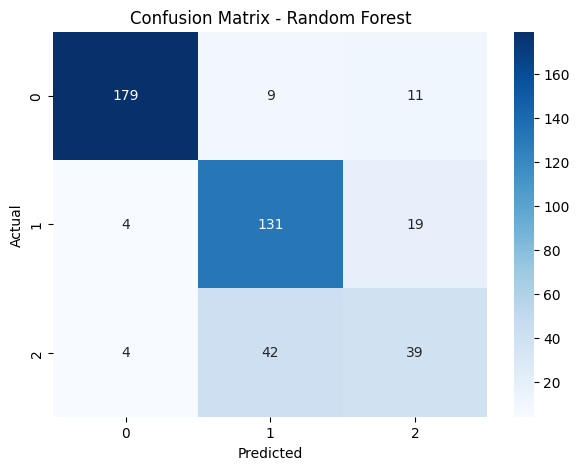

In [ ]:
rf = RandomForestClassifier(
    n_estimators=1500,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight="balanced",
    random_state=42,
    max_features="sqrt"
)

rf.fit(X_train_np, y_train_np)
rf_pred = rf.predict(X_test_np)

print(classification_report(y_test_np, rf_pred))
plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(y_test, rf_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

### Random Forest Classifier

Ensemble model with 1500 trees.

              precision    recall  f1-score   support

           0       0.96      0.89      0.92       199
           1       0.75      0.79      0.77       154
           2       0.51      0.55      0.53        85

    accuracy                           0.79       438
   macro avg       0.74      0.74      0.74       438
weighted avg       0.80      0.79      0.79       438



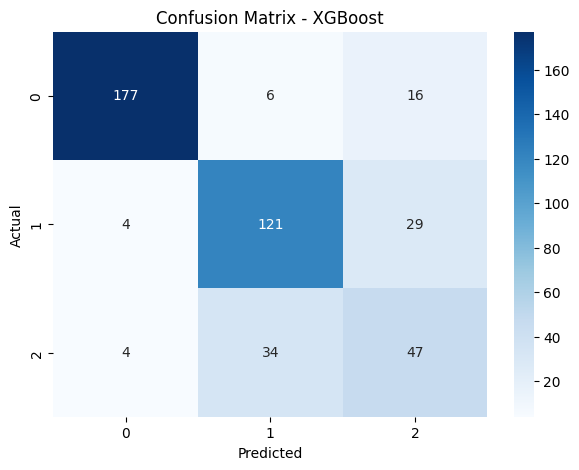

In [ ]:
xgb = XGBClassifier(
    n_estimators=1500,
    learning_rate=0.03,
    max_depth=8,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.4,
    reg_lambda=2.0,
    reg_alpha=0.2,
    objective="multi:softmax",
    num_class=4,
    eval_metric="mlogloss",
    random_state=42
)

xgb.fit(X_train_np, y_train_np)

xgb_pred = xgb.predict(X_test_np)
print(classification_report(y_test_np, xgb_pred))
plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(y_test, xgb_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()


### XGBoost Classifier

Gradient boosting with regularization.

Epoch 1/300


c:\Users\nihal\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4321 - loss: 1.2483 - val_accuracy: 0.6000 - val_loss: 0.9716
Epoch 2/300
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5827 - loss: 0.9204 - val_accuracy: 0.6286 - val_loss: 0.8639
Epoch 3/300
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5912 - loss: 0.8665 - val_accuracy: 0.5629 - val_loss: 0.8886
Epoch 4/300
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6421 - loss: 0.7745 - val_accuracy: 0.6886 - val_loss: 0.7786
Epoch 5/300
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6781 - loss: 0.7433 - val_accuracy: 0.6629 - val_loss: 0.7696
Epoch 6/300
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6892 - loss: 0.6948 - val_accuracy: 0.6457 - val_loss: 0.7877
Epoch 7/300
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7224 - loss: 0.6638 - val_accuracy: 0.6943 - val_loss: 0.7463
Epoch 8/300
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7531 - loss: 0.6233 - val_accuracy: 0.7000 - val_loss: 0.7

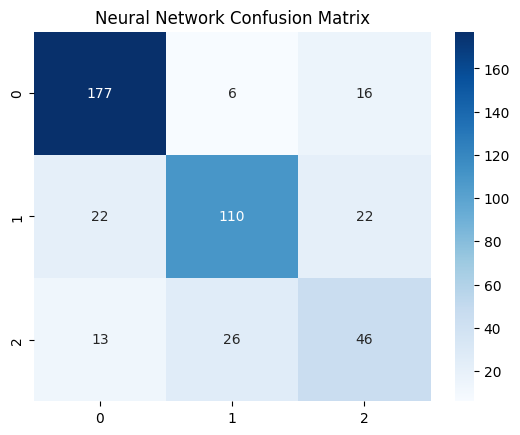

In [101]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# X_train, X_test, y_train, y_test must already be scaled and split

num_features = X_train_np.shape[1]

model = Sequential([
    Dense(128, activation='relu', input_dim=num_features),
    Dropout(0.1),

    Dense(64, activation='relu'),
    Dropout(0.1),

    Dense(32, activation='relu'),

    Dense(4, activation='softmax')  # 4 classes
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=300,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)
loss, acc = model.evaluate(X_test, y_test)
print("Test accuracy:", acc)
y_pred_nn = np.argmax(model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred_nn))
sns.heatmap(confusion_matrix(y_test, y_pred_nn),
            annot=True, fmt='d', cmap='Blues')
plt.title("Neural Network Confusion Matrix")
plt.show()

### Neural Network (TensorFlow/Keras)

Deep learning model with early stopping.

               feature  importance
0               budget    0.319577
3           vote_count    0.097714
7           tmdb_votes    0.074451
8           imdb_votes    0.063172
2         vote_average    0.060047
1              runtime    0.059219
9   sentiment_imdb_avg    0.056993
5          tmdb_rating    0.055648
6          imdb_rating    0.044997
40     is_major_studio    0.016177
16               Drama    0.012359
10              Action    0.011400
13              Comedy    0.010273
20              Horror    0.009175
11           Adventure    0.009090
26            Thriller    0.008770
24     Science Fiction    0.008076
14               Crime    0.007439
18             Fantasy    0.007325
23             Romance    0.007116


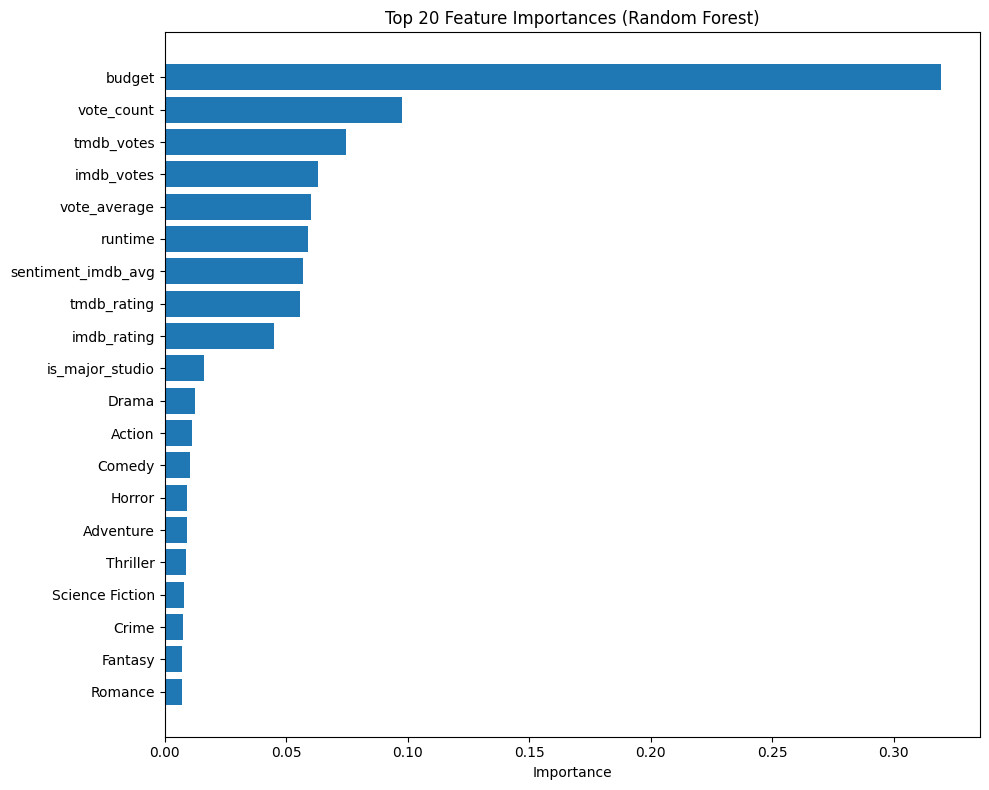

In [102]:
#Feature Importance from Random Forest
importances = rf.feature_importances_
feature_names = X_train.columns  # assumes X_train is a DataFrame

feat_imp = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print(feat_imp.head(20))  # top 20 features

top_n = 20
top_features = feat_imp.head(top_n)

plt.figure(figsize=(10, 8))
plt.barh(top_features["feature"][::-1], top_features["importance"][::-1])
plt.xlabel("Importance")
plt.title(f"Top {top_n} Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()




## Feature Importance Analysis

### Random Forest Feature Importance

Built-in feature importance from tree splits.

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Baseline NN accuracy: 0.7602739726027398
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


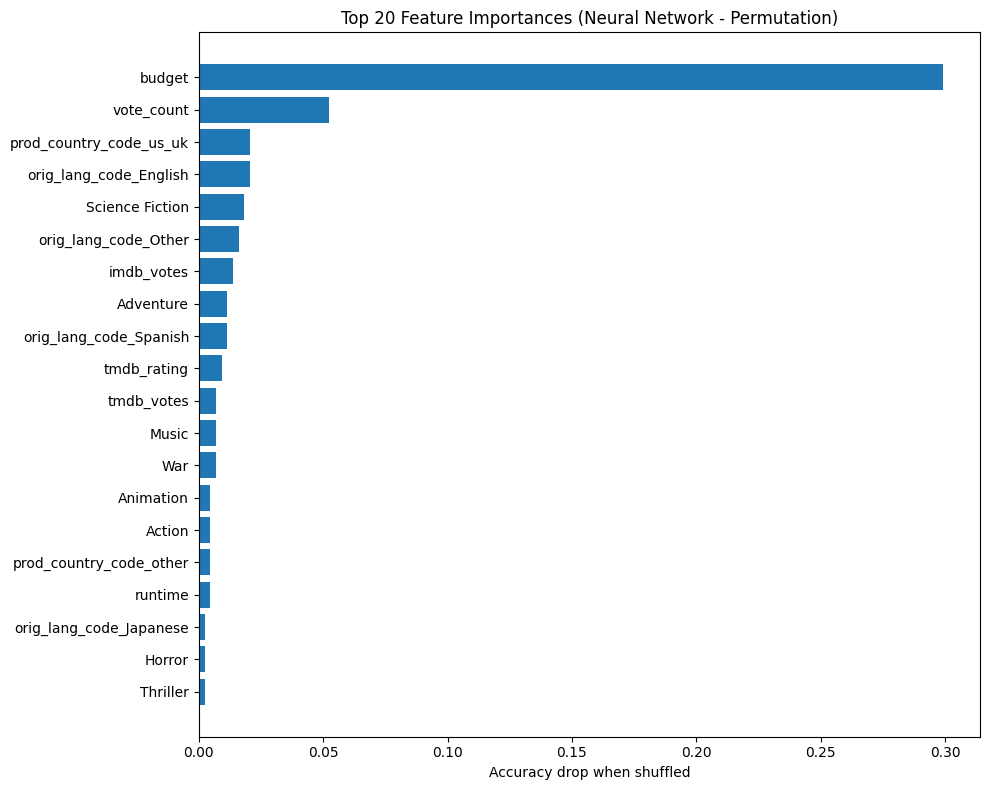

In [103]:
from sklearn.metrics import accuracy_score

if not isinstance(X_test, pd.DataFrame):
    X_test_df = pd.DataFrame(X_test, columns=[f"feat_{i}" for i in range(X_test.shape[1])])
else:
    X_test_df = X_test.copy()

# 1. Baseline accuracy
y_pred_base = np.argmax(model.predict(X_test_df), axis=1)
baseline_acc = accuracy_score(y_test, y_pred_base)
print("Baseline NN accuracy:", baseline_acc)

# 2. Permutation importance
importances = []
feature_names = X_test_df.columns

for col in feature_names:
    X_test_perm = X_test_df.copy()
    # shuffle this one column
    X_test_perm[col] = np.random.permutation(X_test_perm[col].values)

    # predict with shuffled feature
    y_pred_perm = np.argmax(model.predict(X_test_perm), axis=1)
    acc_perm = accuracy_score(y_test, y_pred_perm)

    importance = baseline_acc - acc_perm
    importances.append(importance)

# 3. Build importance DataFrame
nn_feat_imp = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print(nn_feat_imp.head(20))
top_n = 20
top_features = nn_feat_imp.head(top_n)

plt.figure(figsize=(10, 8))
plt.barh(top_features["feature"][::-1], top_features["importance"][::-1])
plt.xlabel("Accuracy drop when shuffled")
plt.title(f"Top {top_n} Feature Importances (Neural Network - Permutation)")
plt.tight_layout()
plt.show()


### Neural Network Permutation Importance

Measure importance by shuffling each feature.

In [104]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Convert numpy / pandas to tensors
def to_tensor_y(y):
    # handles pandas Series or numpy array
    return torch.from_numpy(y.values if hasattr(y, "values") else np.array(y))

X_train_tensor = torch.from_numpy(X_train_np).float()
X_test_tensor  = torch.from_numpy(X_test_np).float()
y_train_tensor = to_tensor_y(y_train).long()
y_test_tensor  = to_tensor_y(y_test).long()
# Full training dataset
full_train_ds = TensorDataset(X_train_tensor, y_train_tensor)

# Train/val split
val_ratio = 0.2
n_total = len(full_train_ds)
n_val = int(n_total * val_ratio)
n_train = n_total - n_val

train_ds, val_ds = random_split(full_train_ds, [n_train, n_val])

batch_size = 32

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(TensorDataset(X_test_tensor, y_test_tensor),
                          batch_size=batch_size, shuffle=False)


Using device: cpu


### PyTorch Neural Network

Custom implementation with manual training loop.

In [105]:
class MovieNet(nn.Module):
    def __init__(self, input_dim, num_classes=4):
        super(MovieNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(64, 32),
            nn.ReLU(),

            nn.Linear(32, num_classes)  # logits
        )

    def forward(self, x):
        return self.net(x)

input_dim = X_train_np.shape[1]
model = MovieNet(input_dim, num_classes=4).to(device)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

max_epochs = 300
patience = 50  # for early stopping 
best_val_loss = float("inf")
epochs_no_improve = 0

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(1, max_epochs + 1):
    # ---- TRAIN ----
    model.train()
    running_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)

    train_loss = running_loss / n_train
    train_losses.append(train_loss)

    # ---- VALIDATION ----
    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val = X_val.to(device)
            y_val = y_val.to(device)

            logits = model(X_val)
            loss = criterion(logits, y_val)
            val_running_loss += loss.item() * X_val.size(0)

            preds = torch.argmax(logits, dim=1)
            correct += (preds == y_val).sum().item()
            total += y_val.size(0)

    val_loss = val_running_loss / n_val
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # ---- Early stopping check ----
    if val_loss < best_val_loss - 1e-4:
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_state_dict = model.state_dict()
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered!")
            break

# Load best model
model.load_state_dict(best_state_dict)


MovieNet(
  (net): Sequential(
    (0): Linear(in_features=41, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=4, bias=True)
  )
)
Epoch 001 | Train Loss: 1.1704 | Val Loss: 0.9927 | Val Acc: 0.5257
Epoch 002 | Train Loss: 0.9238 | Val Loss: 0.8793 | Val Acc: 0.5771
Epoch 003 | Train Loss: 0.8526 | Val Loss: 0.8122 | Val Acc: 0.6543
Epoch 004 | Train Loss: 0.7965 | Val Loss: 0.7832 | Val Acc: 0.6629
Epoch 005 | Train Loss: 0.7362 | Val Loss: 0.7247 | Val Acc: 0.6714
Epoch 006 | Train Loss: 0.6835 | Val Loss: 0.6934 | Val Acc: 0.7143
Epoch 007 | Train Loss: 0.6655 | Val Loss: 0.6650 | Val Acc: 0.7229
Epoch 008 | Train Loss: 0.6414 | Val Loss: 0.6654 | Val Acc: 0.7114
Epoch 009 | Train Loss: 0.6127 | Val Loss: 0.6542 | 

<All keys matched successfully>

Define model architecture and training loop.

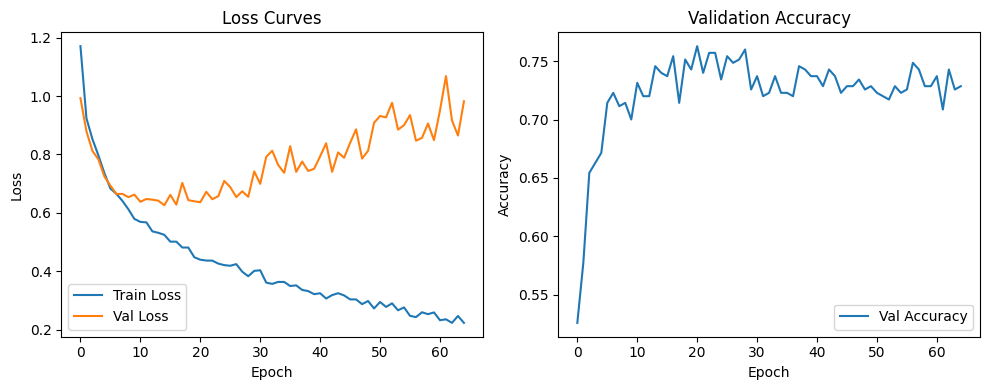

Test accuracy: 0.7671232876712328
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       199
           1       0.76      0.66      0.71       154
           2       0.54      0.56      0.55        85

    accuracy                           0.77       438
   macro avg       0.72      0.72      0.72       438
weighted avg       0.77      0.77      0.76       438



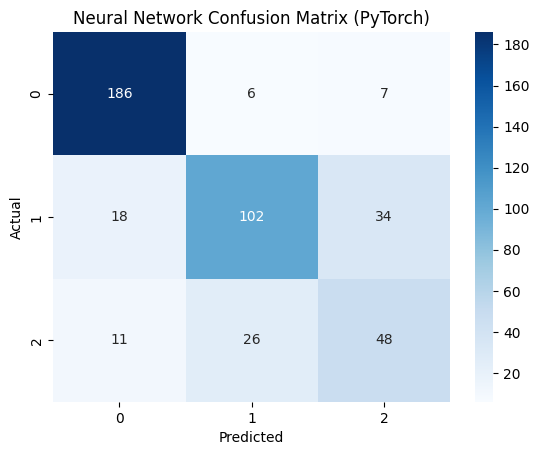

In [106]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curves")

plt.subplot(1,2,2)
plt.plot(val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Validation Accuracy")
plt.tight_layout()
plt.show()

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        logits = model(X_batch)
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

print("Test accuracy:",
      (np.array(all_preds) == np.array(all_labels)).mean())

print(classification_report(all_labels, all_preds))

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Neural Network Confusion Matrix (PyTorch)")
plt.show()


Evaluate PyTorch model performance.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.20, random_state=42, stratify=y
)
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()
print(X_train_np.shape, X_test_np.shape, y_train_np.shape, y_test_np.shape)

(1750, 41) (438, 41) (1750,) (438,)


              precision    recall  f1-score   support

           0       0.81      0.43      0.56       154
           1       0.54      0.54      0.54        85
           2       0.68      0.93      0.79       199

    accuracy                           0.68       438
   macro avg       0.68      0.63      0.63       438
weighted avg       0.70      0.68      0.66       438



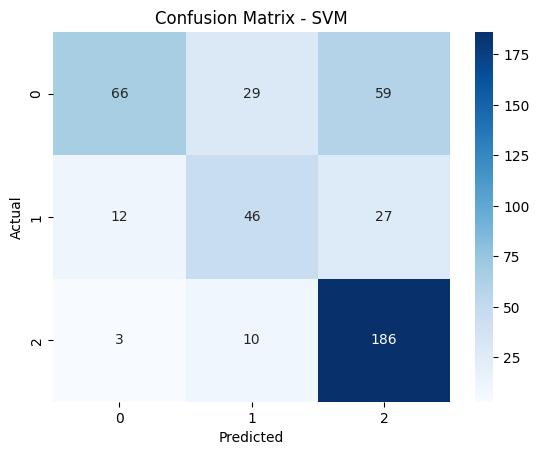

In [18]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

svm = SVC(kernel="rbf", C=1, gamma=0.1, class_weight="balanced", probability=True)
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)

print(classification_report(y_test, svm_pred))
sns.heatmap(confusion_matrix(y_test, svm_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - SVM")
plt.show()

### Support Vector Machine

RBF kernel classifier.

Final silhouette score for k=3: 0.756


/opt/anaconda3/envs/ds/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


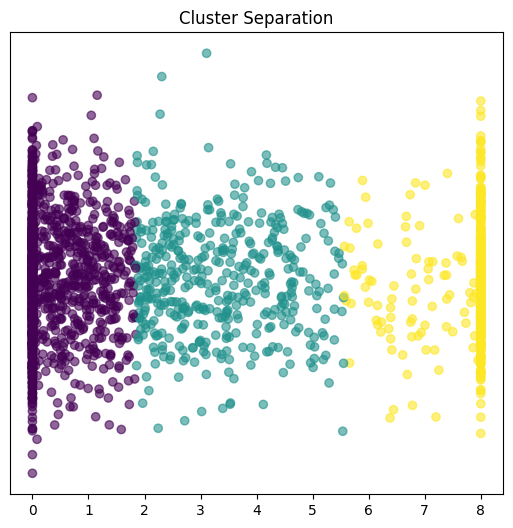


Cross-tab: verdict_label vs cluster
cluster          0    1    2
verdict_label               
0              735   34    0
1                0  409   18
2              538    1  453


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

X_cluster_subset = pd.DataFrame(index=df_ml.index)

revenue = pd.to_numeric(df.loc[X_cluster_subset.index, "revenue_worldwide"], errors='coerce').fillna(0)
budget = pd.to_numeric(df.loc[X_cluster_subset.index, "budget"], errors='coerce').fillna(0)

ratio = revenue / (budget + 1.0)

X_cluster_subset["capped_ratio"] = ratio.clip(upper=8)

scaler_cluster = StandardScaler()
X_cluster_scaled = scaler_cluster.fit_transform(X_cluster_subset[["capped_ratio"]])

ideal_centroids = np.array([[0.5], [4.0], [8.0]])

init_centroids = scaler_cluster.transform(ideal_centroids)

n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, init=init_centroids, n_init=1, random_state=42)
cluster_labels = kmeans.fit_predict(X_cluster_scaled)

df_ml["cluster"] = cluster_labels

silhouette_avg = silhouette_score(X_cluster_scaled, cluster_labels)
print(f"Final silhouette score for k={n_clusters}: {silhouette_avg:.3f}")

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
y = np.random.normal(0, 0.05, size=len(X_cluster_subset))
scatter = plt.scatter(X_cluster_subset["capped_ratio"], y, c=df_ml["cluster"], cmap="viridis", alpha=0.6)
plt.title("Cluster Separation")
plt.yticks([]) 
plt.show()


X_cluster_subset["ratio"] = ratio
X_cluster_subset["cluster"] = cluster_labels

print("\nCross-tab: verdict_label vs cluster")
print(pd.crosstab(df_ml["verdict_label"], df_ml["cluster"]))

## Clustering Analysis

### Revenue-to-Budget Ratio Clustering

Simple clustering based on financial performance.

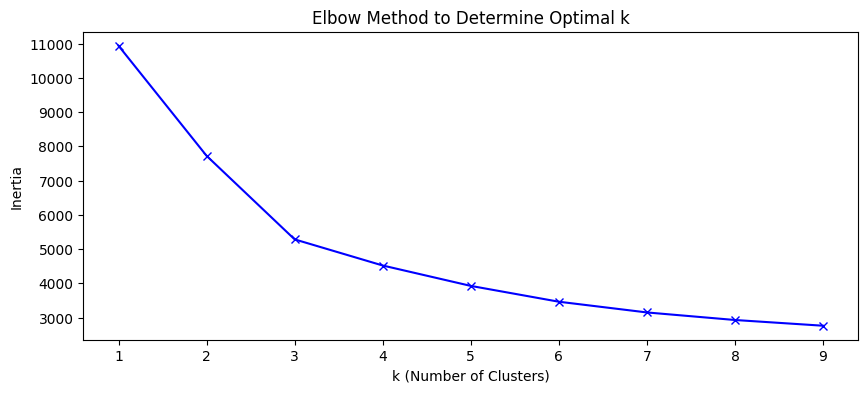

Cluster Averages:
         tmdb_rating  imdb_rating  sentiment_imdb_avg    tmdb_votes  \
cluster                                                               
1           5.720006     4.980909            0.064721   1390.893939   
3           6.485899     6.162633            0.394497   1828.804671   
0           7.316223     7.062861            0.615965   1965.283465   
2           7.363994     7.288961            0.534956  12258.097403   

            imdb_votes  
cluster                 
1         36929.424242  
3         61921.216561  
0         75670.603675  
2        467540.629870  


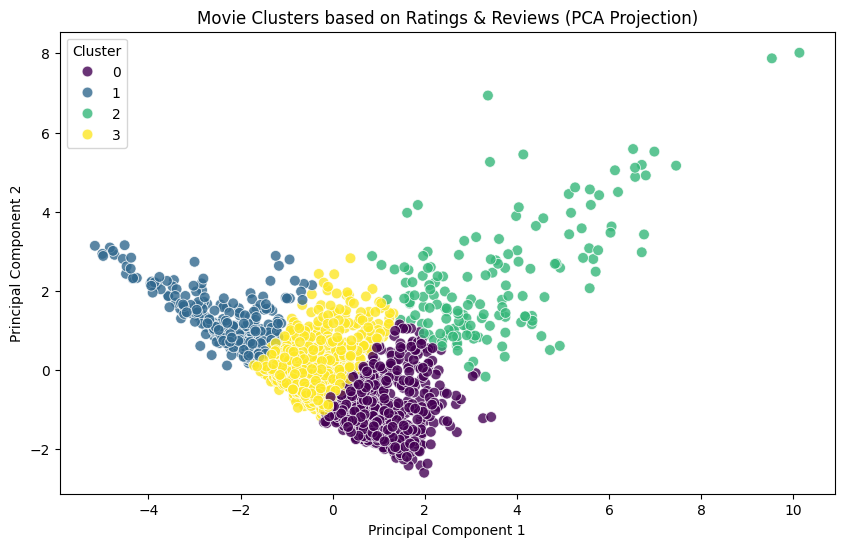

Silhouette Score: 0.253


In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

cluster_cols = ['tmdb_rating', 'imdb_rating', 'sentiment_imdb_avg', 'tmdb_votes', 'imdb_votes']
X_cluster = df_ml[cluster_cols].copy()

scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

inertias = []
K_range = range(1, 10)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_cluster_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(10, 4))
plt.plot(K_range, inertias, 'bx-')
plt.xlabel('k (Number of Clusters)')
plt.ylabel('Inertia')
plt.title('Elbow Method to Determine Optimal k')
plt.show()

k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_cluster_scaled)

df_analysis = X_cluster.copy()
df_analysis['cluster'] = cluster_labels
print("Cluster Averages:")
print(df_analysis.groupby('cluster').mean().sort_values('imdb_rating'))

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels, palette='viridis', s=60, alpha=0.8)
plt.title('Movie Clusters based on Ratings & Reviews (PCA Projection)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

print(f"Silhouette Score: {silhouette_score(X_cluster_scaled, cluster_labels):.3f}")

### Ratings-Based Clustering

Group movies by ratings and review patterns.

## Comprehensive Clustering for Movie Performance Prediction

Using multiple features (budget, ratings, votes, sentiment, genres, studio, cast/director) to discover natural groupings that relate to commercial success.

In [31]:
# features that might matter for box office
performance_features = [
    'budget', 'runtime', 
    'tmdb_rating', 'imdb_rating', 'tmdb_votes', 'imdb_votes',
    'sentiment_imdb_avg',
    'is_major_studio', 'is_top_director', 'has_top_actor'
]

# grab main genres to keep dimensionality reasonable
genre_cols = [col for col in df_ml.columns if col in [
    'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 
    'Drama', 'Fantasy', 'Horror', 'Romance', 'Sci-Fi', 'Thriller'
]]
performance_features.extend(genre_cols)

X_performance = df_ml[performance_features].copy()

print(f"Clustering with {len(performance_features)} features:")
print(performance_features)
print(f"\nDataset shape: {X_performance.shape}")

Clustering with 20 features:
['budget', 'runtime', 'tmdb_rating', 'imdb_rating', 'tmdb_votes', 'imdb_votes', 'sentiment_imdb_avg', 'is_major_studio', 'is_top_director', 'has_top_actor', 'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Drama', 'Fantasy', 'Horror', 'Romance', 'Thriller']

Dataset shape: (2188, 20)


Select comprehensive feature set for performance clustering.

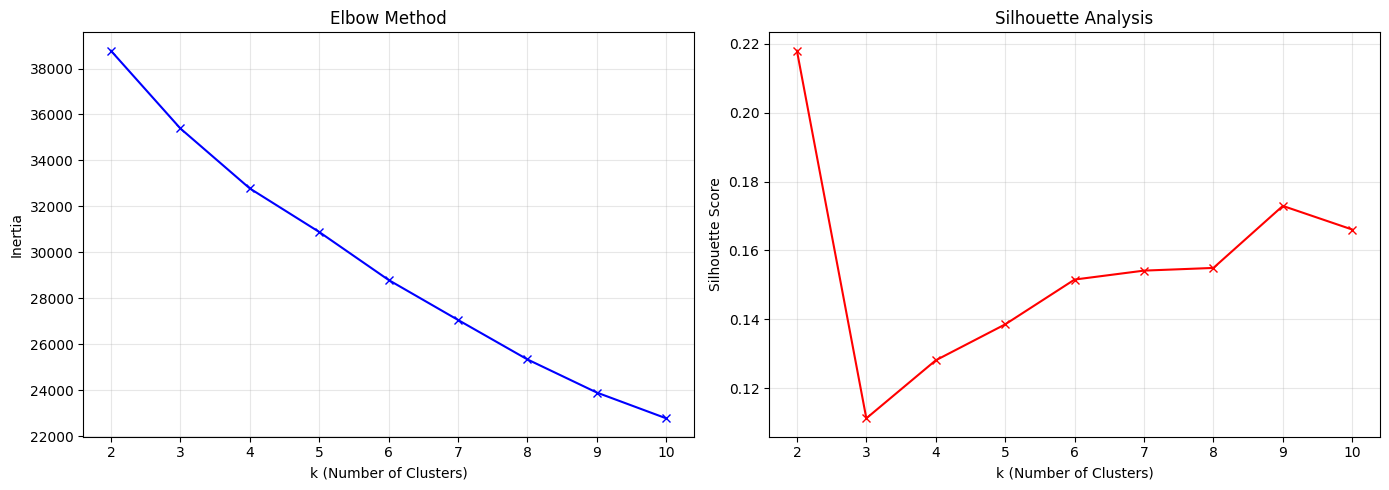

Silhouette Scores by k:
  k=2: 0.218
  k=3: 0.111
  k=4: 0.128
  k=5: 0.139
  k=6: 0.152
  k=7: 0.154
  k=8: 0.155
  k=9: 0.173
  k=10: 0.166


In [32]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

scaler_perf = StandardScaler()
X_performance_scaled = scaler_perf.fit_transform(X_performance)

# elbow method to find best k
inertias_perf = []
silhouette_scores_perf = []
K_range_perf = range(2, 11)

for k in K_range_perf:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    km.fit(X_performance_scaled)
    inertias_perf.append(km.inertia_)
    silhouette_scores_perf.append(silhouette_score(X_performance_scaled, km.labels_))
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(K_range_perf, inertias_perf, 'bx-')
axes[0].set_xlabel('k (Number of Clusters)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method')
axes[0].grid(True, alpha=0.3)

axes[1].plot(K_range_perf, silhouette_scores_perf, 'rx-')
axes[1].set_xlabel('k (Number of Clusters)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Analysis')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Silhouette Scores by k:")
for k, score in zip(K_range_perf, silhouette_scores_perf):
    print(f"  k={k}: {score:.3f}")

Determine optimal number of clusters using elbow method and silhouette analysis.

In [33]:
# k=5 looks decent from the plots
optimal_k = 5
kmeans_perf = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
cluster_labels_perf = kmeans_perf.fit_predict(X_performance_scaled)

df_ml['performance_cluster'] = cluster_labels_perf

print(f"\nFinal clustering with k={optimal_k}")
print(f"Silhouette Score: {silhouette_score(X_performance_scaled, cluster_labels_perf):.3f}")
print(f"\nCluster distribution:")
print(df_ml['performance_cluster'].value_counts().sort_index())


Final clustering with k=5
Silhouette Score: 0.139

Cluster distribution:
performance_cluster
0    224
1    946
2    723
3    240
4     55
Name: count, dtype: int64


Apply K-Means with optimal k=5.

In [34]:
print("\nCluster Analysis: Performance Clusters vs Verdicts\n")

cluster_analysis = pd.DataFrame()
for cluster_id in range(optimal_k):
    cluster_mask = df_ml['performance_cluster'] == cluster_id
    cluster_data = df_ml[cluster_mask]
    
    verdict_dist = cluster_data['verdict_label'].value_counts(normalize=True).sort_index()
    
    print(f"\nCluster {cluster_id} (n={cluster_mask.sum()})")
    print("Verdict Distribution:")
    verdict_names = {0: 'Flop/Average', 1: 'Hit/Superhit', 2: 'Blockbuster'}
    for verdict_id, pct in verdict_dist.items():
        print(f"  {verdict_names[verdict_id]}: {pct*100:.1f}%")
    
    print("\nAverage Characteristics:")
    print(f"  Budget: ${cluster_data['budget'].mean()/1e6:.1f}M")
    print(f"  TMDB Rating: {cluster_data['tmdb_rating'].mean():.2f}")
    print(f"  IMDb Rating: {cluster_data['imdb_rating'].mean():.2f}")
    print(f"  IMDb Votes: {cluster_data['imdb_votes'].mean():,.0f}")
    print(f"  Major Studio: {cluster_data['is_major_studio'].mean()*100:.0f}%")
    print(f"  Top Director: {cluster_data['is_top_director'].mean()*100:.0f}%")
    print(f"  Top Actor: {cluster_data['has_top_actor'].mean()*100:.0f}%")


Cluster Analysis: Performance Clusters vs Verdicts


Cluster 0 (n=224)
Verdict Distribution:
  Flop/Average: 34.8%
  Hit/Superhit: 46.4%
  Blockbuster: 18.8%

Average Characteristics:
  Budget: $133.9M
  TMDB Rating: 7.03
  IMDb Rating: 6.81
  IMDb Votes: 316,081
  Major Studio: 72%
  Top Director: 6%
  Top Actor: 0%

Cluster 1 (n=946)
Verdict Distribution:
  Flop/Average: 34.5%
  Hit/Superhit: 15.2%
  Blockbuster: 50.3%

Average Characteristics:
  Budget: $12.7M
  TMDB Rating: 6.96
  IMDb Rating: 6.69
  IMDb Votes: 65,532
  Major Studio: 14%
  Top Director: 0%
  Top Actor: 0%

Cluster 2 (n=723)
Verdict Distribution:
  Flop/Average: 38.3%
  Hit/Superhit: 15.1%
  Blockbuster: 46.6%

Average Characteristics:
  Budget: $14.3M
  TMDB Rating: 6.19
  IMDb Rating: 5.74
  IMDb Votes: 52,972
  Major Studio: 21%
  Top Director: 0%
  Top Actor: 0%

Cluster 3 (n=240)
Verdict Distribution:
  Flop/Average: 25.8%
  Hit/Superhit: 20.4%
  Blockbuster: 53.8%

Average Characteristics:
  Budget: $40.1M
 

Analyze cluster characteristics and verdict distribution.


PCA Explained Variance: 29.6%
  PC1: 17.5%
  PC2: 12.1%


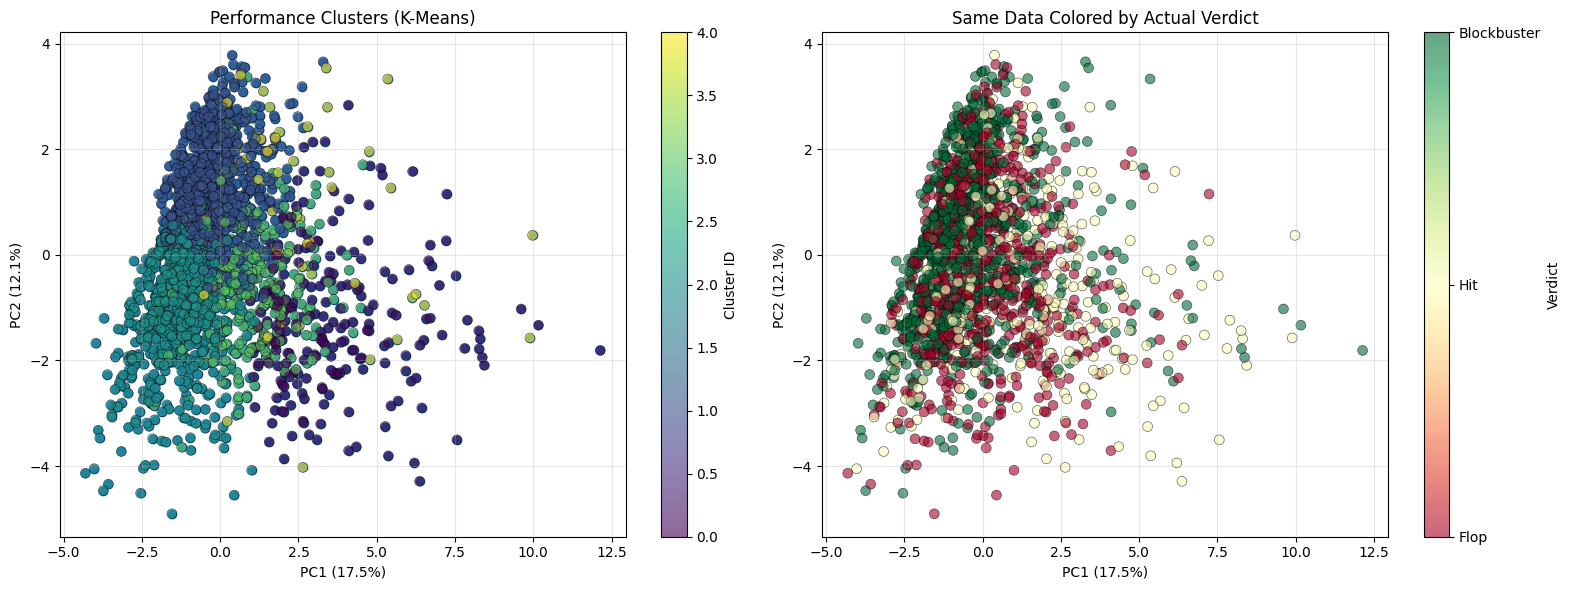

In [36]:
from sklearn.decomposition import PCA

pca_perf = PCA(n_components=2)
X_pca_perf = pca_perf.fit_transform(X_performance_scaled)

print(f"\nPCA Explained Variance: {pca_perf.explained_variance_ratio_.sum()*100:.1f}%")
print(f"  PC1: {pca_perf.explained_variance_ratio_[0]*100:.1f}%")
print(f"  PC2: {pca_perf.explained_variance_ratio_[1]*100:.1f}%")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Clusters colored by cluster ID
scatter1 = axes[0].scatter(X_pca_perf[:, 0], X_pca_perf[:, 1]), 
scatter1 = axes[0].scatter(X_pca_perf[:, 0], X_pca_perf[:, 1], 
                           c=cluster_labels_perf, cmap='viridis', 
                           s=50, alpha=0.6, edgecolors='k', linewidth=0.5)
axes[0].set_xlabel(f'PC1 ({pca_perf.explained_variance_ratio_[0]*100:.1f}%)')
axes[0].set_ylabel(f'PC2 ({pca_perf.explained_variance_ratio_[1]*100:.1f}%)')
axes[0].set_title('Performance Clusters (K-Means)')
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Cluster ID')

scatter2 = axes[1].scatter(X_pca_perf[:, 0], X_pca_perf[:, 1], 
                           c=df_ml['verdict_label'], cmap='RdYlGn', 
                           s=50, alpha=0.6, edgecolors='k', linewidth=0.5)
axes[1].set_xlabel(f'PC1 ({pca_perf.explained_variance_ratio_[0]*100:.1f}%)')
axes[1].set_ylabel(f'PC2 ({pca_perf.explained_variance_ratio_[1]*100:.1f}%)')
axes[1].set_title('Same Data Colored by Actual Verdict')
axes[1].grid(True, alpha=0.3)
cbar2 = plt.colorbar(scatter2, ax=axes[1], label='Verdict', ticks=[0, 1, 2])
cbar2.ax.set_yticklabels(['Flop', 'Hit', 'Blockbuster'])

plt.tight_layout()
plt.show()

Visualize clusters in 2D using PCA.


Cross-tabulation: Clusters vs Verdicts


Percentage of each verdict within each cluster:
                     Flop/Average  Hit/Superhit  Blockbuster
performance_cluster                                         
0                            34.8          46.4         18.8
1                            34.5          15.2         50.3
2                            38.3          15.1         46.6
3                            25.8          20.4         53.8
4                            47.3          38.2         14.5


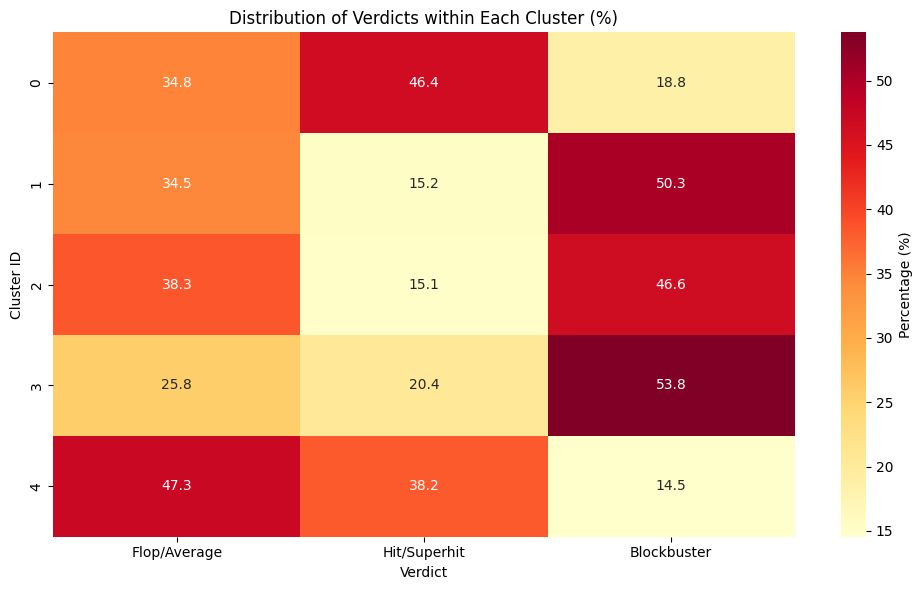

In [37]:
print("\nCross-tabulation: Clusters vs Verdicts\n")
crosstab = pd.crosstab(df_ml['performance_cluster'], df_ml['verdict_label'], 
                       normalize='index') * 100
crosstab.columns = ['Flop/Average', 'Hit/Superhit', 'Blockbuster']
print("\nPercentage of each verdict within each cluster:")
print(crosstab.round(1))
plt.figure(figsize=(10, 6))
sns.heatmap(crosstab, annot=True, fmt='.1f', cmap='YlOrRd', 
            cbar_kws={'label': 'Percentage (%)'})
plt.title('Distribution of Verdicts within Each Cluster (%)')
plt.xlabel('Verdict')
plt.ylabel('Cluster ID')
plt.tight_layout()
plt.show()

Cross-tabulation showing verdict distribution within each cluster.

In [38]:
cluster_centers = kmeans_perf.cluster_centers_

centers_df = pd.DataFrame(cluster_centers, columns=performance_features)
centers_df['cluster'] = range(optimal_k)

print("\nCluster Centers (scaled values)")
print("\nTop features for each cluster:\n")

for cluster_id in range(optimal_k):
    print(f"Cluster {cluster_id}:")
    center = centers_df[centers_df['cluster'] == cluster_id].drop('cluster', axis=1).iloc[0]
    top_features = center.abs().sort_values(ascending=False).head(5)
    for feat, val in top_features.items():
        actual_val = center[feat]
        direction = "High" if actual_val > 0 else "Low"
        print(f"  {feat}: {actual_val:.2f} ({direction})")
    print()


Cluster Centers (scaled values)

Top features for each cluster:

Cluster 0:
  budget: 1.91 (High)
  tmdb_votes: 1.77 (High)
  imdb_votes: 1.68 (High)
  Adventure: 1.14 (High)
  Action: 1.06 (High)

Cluster 1:
  Drama: 0.60 (High)
  Action: -0.41 (Low)
  Romance: 0.39 (High)
  Horror: -0.39 (Low)
  sentiment_imdb_avg: 0.35 (High)

Cluster 2:
  Horror: 0.76 (High)
  tmdb_rating: -0.73 (Low)
  Thriller: 0.71 (High)
  imdb_rating: -0.69 (Low)
  sentiment_imdb_avg: -0.66 (Low)

Cluster 3:
  Animation: 2.36 (High)
  Fantasy: 1.18 (High)
  Adventure: 1.08 (High)
  runtime: -0.84 (Low)
  Drama: -0.66 (Low)

Cluster 4:
  has_top_actor: 6.23 (High)
  budget: 1.05 (High)
  runtime: 0.95 (High)
  imdb_votes: 0.82 (High)
  tmdb_votes: 0.74 (High)



Examine cluster centers to identify distinguishing features.

### Interpretation

Clusters group movies by similar traits - budget, ratings, studio backing, talent, genres. Some clusters lean heavily toward flops while others skew successful. Good cluster separation means our features capture real patterns.

Where clusters mix verdicts, it shows the prediction difficulty. A low-budget indie can still hit big, high-budget studio films can tank. That's the variability these models try to predict.

Unlike supervised models that learn from labels, clustering just finds natural groupings. Useful for understanding what makes movies similar, not just whether they'll succeed.